# Correlations in simulation
## Testing the assumption of Poisson processes

## Simulated transition

In [1]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)

# Import specific moduls
#import network_params; reload(network_params)
import model_class; reload(model_class)
import sim_params as sim; reload(sim)
%matplotlib inline

show_fig = False
save_fig = True
picture_format = ".pdf"
xfactor = 2.6
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
plotting = True

In [2]:
# DATA
data_file = "micro"
data_sup_path = "/export/data-schuessler/data_microcircuit/"
data_path = os.path.join(data_sup_path, data_file)
sim_spec = "a1.0_t300.2_totalN_00"

# Original data
file_name  = sim_spec + ".hdf5"  
res_file_name = sim_spec + "_res.hdf5"

### Basic data

In [3]:
# Open file: data
data_file = h5py.File(os.path.join(data_path, file_name), "r")

# Simulation attributes
area    = data_file.attrs["area"]   
t_sim   = data_file.attrs["t_sim"]  
t_trans = data_file.attrs["t_trans"]
dt      = data_file.attrs["dt"]    
populations   = data_file.attrs["populations"].astype("|U4")
layers        = data_file.attrs["layers"].astype("|U4")        
types         = data_file.attrs["types"].astype("|U4")     
n_populations = data_file.attrs["n_populations"]
n_layers      = data_file.attrs["n_layers"]       
n_types       = data_file.attrs["n_types"] 

t_measure = t_sim - t_trans


# labels & colors: need to be adapted if n_types != (e, i)
layer_colors = style.colors[:n_layers]
colors = np.array([color for color in layer_colors for i in range(n_types)])
colors[1::2] = colors[1::2] * 0.4   #### adapt for more than two types!
if reverse_order:
    populations = populations[::-1]
    layers = layers[::-1]
    types = types[::-1]
    colors = colors[::-1]
data_file.close()

### Raster plot

0


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


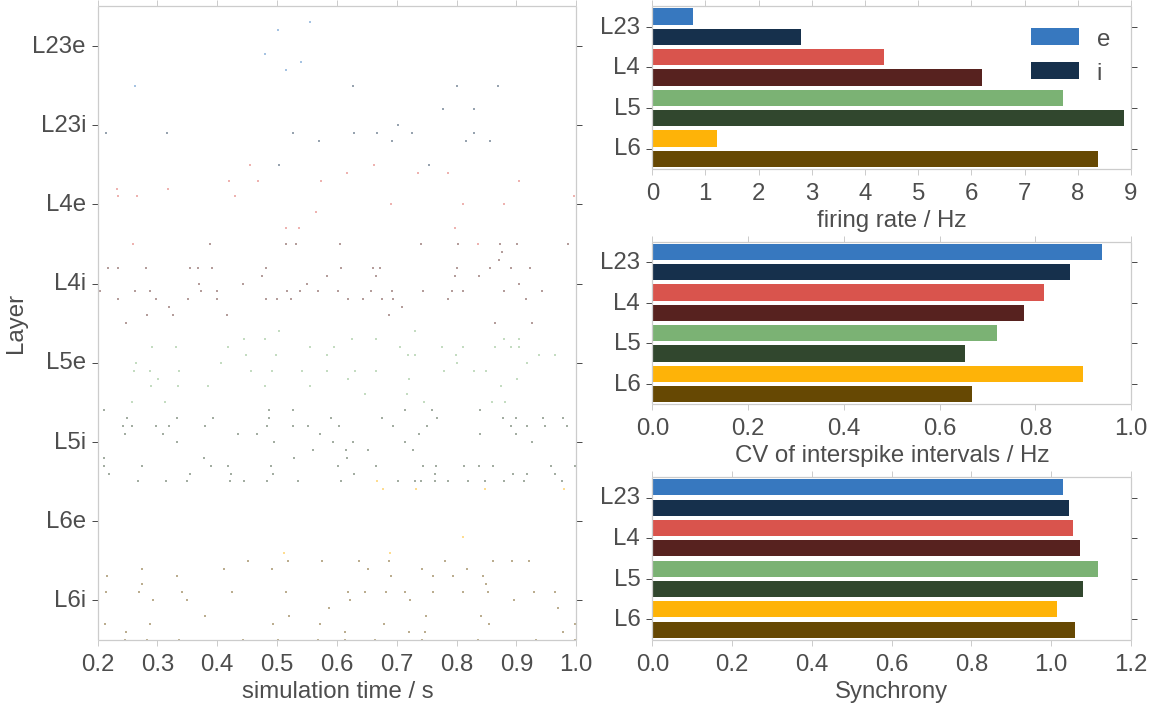

In [4]:
sim_spec2 = "0"
print(sim_spec2)
# Data
with h5py.File(os.path.join(data_path, res_file_name), "r") as res_file:
    res_grp = res_file[sim_spec2]
    res_raster = res_grp["raster"]

    rates_mean   = res_grp["rates_mean"][:]
    rates_std    = res_grp["rates_std"]
    cv_isi_mean  = res_grp["cv_isi_mean"]
    cv_isi_std   = res_grp["cv_isi_std"]
    synchrony    = res_grp["synchrony"]

    t_min_raster = res_raster.attrs["t_min_raster"]
    t_max_raster = res_raster.attrs["t_max_raster"]
    ymax_raster = res_raster.attrs["ymax_raster"]
    yticks = res_raster.attrs["yticks"]


fig = plt.figure()

# Raster plot
ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=3)
# Rates
ax1 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
# CV of interspike interval (ISI)
ax2 = plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
# Synchrony
ax3 = plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)    

y_mean = np.arange(n_populations) + 0.1
bar_height = 0.8 
for i, population in enumerate(populations):
    res_raster_pop = res_raster[str(population)]
    for times, neuron_ids in res_raster_pop.values():
        ax0.plot(times, neuron_ids, '.', ms=3, color=colors[i], label=population)
    ax1.barh(y_mean[i], rates_mean[i], height=bar_height, color=colors[i], linewidth=0)
    ax2.barh(y_mean[i], cv_isi_mean[i], height=bar_height, color=colors[i], linewidth=0)
    ax3.barh(y_mean[i], synchrony[i],   height=bar_height, color=colors[i], linewidth=0)    


# Raster Plot
xlim = (t_min_raster, t_max_raster)
ylim = (0, ymax_raster)
ax0.set_yticks(yticks)
ax0.set_yticklabels(populations)
ax0.set_xlabel('simulation time / s')
ax0.set_ylabel('Layer')
ax0.set_xlim(*xlim)
ax0.set_ylim(*ylim)
ax0.grid(False)

# Rates
ax1.set_xlabel('firing rate / Hz')
# CV of ISI
ax2.set_xlabel('CV of interspike intervals / Hz')
# Synchrony
ax3.set_xlabel('Synchrony')

ylim_mean = (0, n_populations)
yticks_mean = np.arange(n_types * 0.5, n_populations, n_types)
for ax in (ax1, ax2, ax3):
    #ax.set_ylabel('Layer')
    ax.set_yticks(yticks_mean)
    ax.set_yticklabels(layers)
    ax.set_ylim(*ylim_mean)
    ax.grid(False)

# Legend; order is reversed, such that labels appear correctly
for i in range(n_types):
    ax1.barh(0, 0, 0, color=colors[-(i+1)], label=types[-(i+1)], linewidth=0)
ax1.legend(loc='best')

for ax in fig.axes:
    style.fixticks(ax)
fig_name = "cell_activity_" + sim_spec + "_" + sim_spec2

if save_fig:
    fig.savefig(os.path.join(figure_path,fig_name + picture_format))
else:

    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + os.path.join(sim_spec, sim_spec2)
    fig.suptitle(suptitle, y=0.98)


## Population activity 
### Spike counts and power spectrum

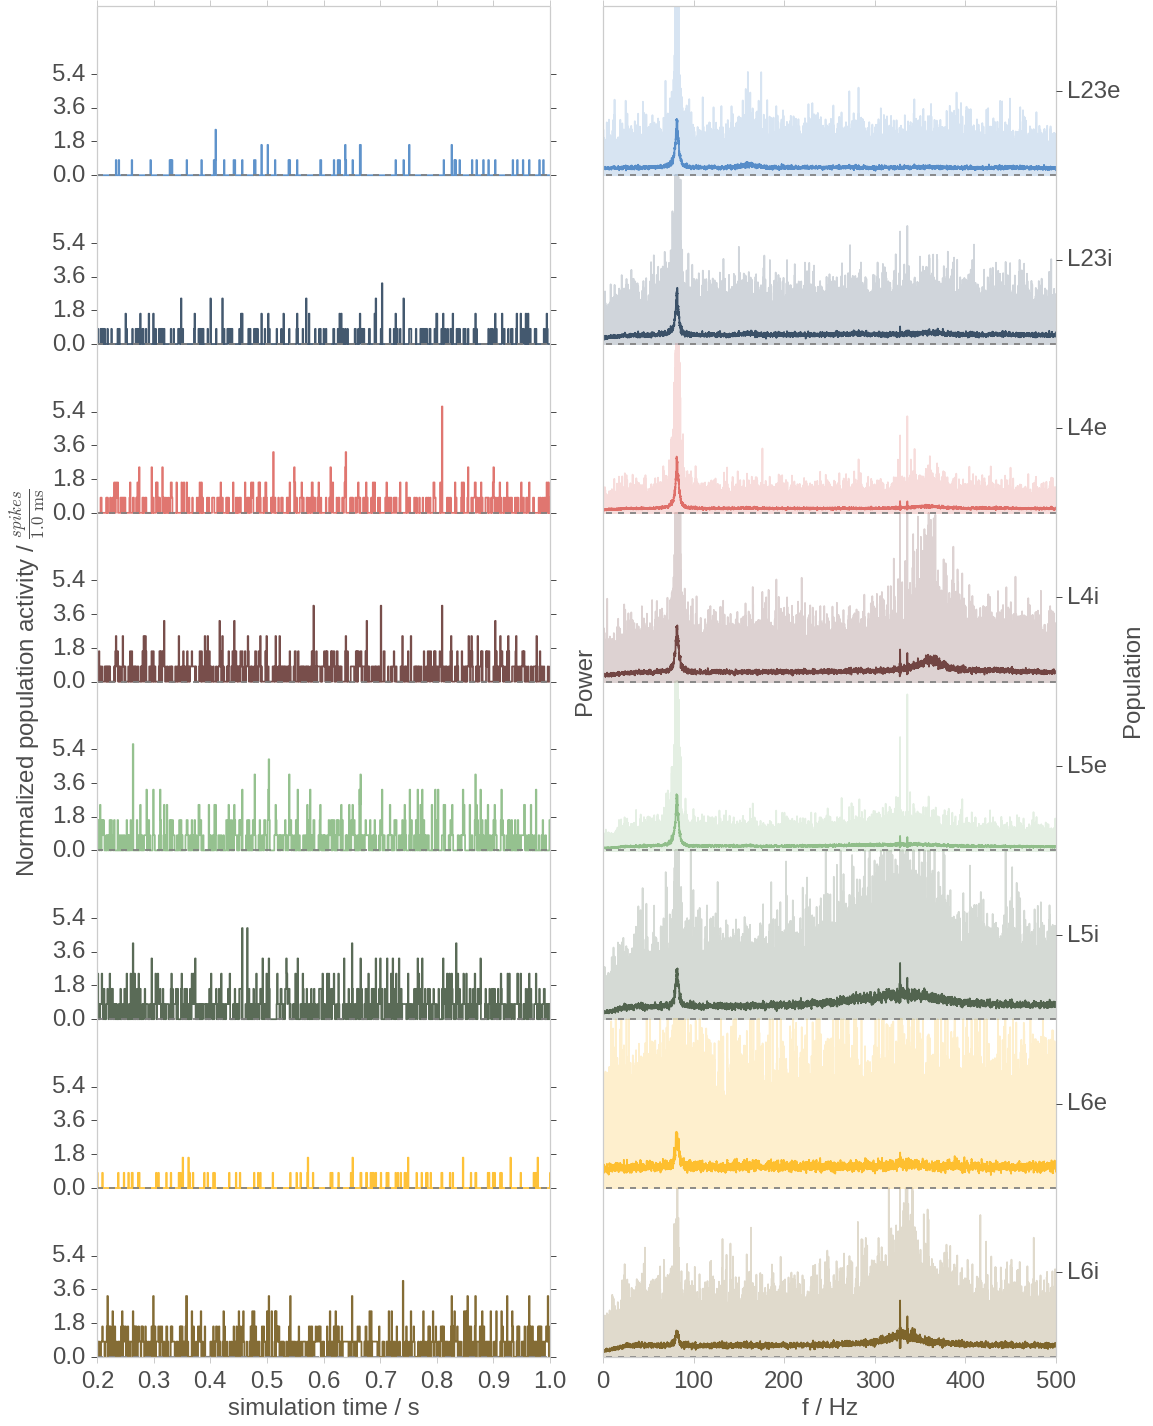

In [5]:
from scipy.signal import savgol_filter as sav
def rebin(array, n_zoom=2):
    """Rebinning of an array without interpolation."""
    overlap = array.shape[-1] % n_zoom
    if overlap != 0:
        pre_rebin = array[:, :-overlap].copy() # cut off the end
    else:
        pre_rebin = array.copy()

    rebinned = pre_rebin[:, ::n_zoom]
    for k in range(1, n_zoom):
        rebinned += pre_rebin[:, k::n_zoom]

    return rebinned, overlap

# Open file: results
with h5py.File(os.path.join(data_path, res_file_name), "r") as res_file:
    res_grp = res_file[sim_spec2]
    n_rec_spikes = res_grp["n_rec_spikes"][:]
    hist_spikes  = res_grp["hist_spikes"][:]
    hist_times   = res_grp["hist_times"][:]
    normed_hist = (hist_spikes.T / n_rec_spikes).T

fig = plt.figure(figsize=(xfactor*6.2, 2*xfactor*3.83) )
ax0 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax1 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

# Rebinning
n_zoom = 10 # factor by which to zoom out
reb_hist, overlap = rebin(normed_hist, n_zoom=n_zoom)
stretch = np.floor(1. / np.max(reb_hist))  # stretch each histogram...  
time_step = dt * 1.e-3 # s

for i, population in enumerate(populations):
    if overlap == 0:
        reb_hist_times = hist_times[::n_zoom]
    else:
        reb_hist_times = hist_times[:-overlap][::n_zoom]
    ax0.plot(reb_hist_times, stretch * reb_hist[i] + i, 
             "-", alpha=0.8, color=colors[i], drawstyle="steps")
    ax0.plot(hist_times[[0, -1]], [i]*2, "--", color="gray")
    
    # Power spectrum
    glob_ac = reb_hist[i]
    ga_mean = np.mean(glob_ac)

    ps = np.abs(np.fft.fft(glob_ac - ga_mean))**2
    freqs = np.fft.fftfreq(glob_ac.size, time_step * n_zoom)
    idx = np.argsort(freqs)

    # Filtered
    filtered = sav(ps[idx], 301, 5, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
    
    # Normalize
    y_max = 3 * np.max(filtered)
    ps_norm = ps[idx] / y_max
    ps_norm[ps_norm > 1] = 1
    filtered_norm = filtered / y_max   
    
    ax1.plot(freqs[idx], ps_norm + i, "-", alpha=0.2, color=colors[i], label=population)
    ax1.plot(freqs[idx], filtered_norm + i, "-", alpha=0.8, color=colors[i])    
    ax1.plot(freqs[idx][[0, -1]], [i]*2, "--", color="gray")
    
xlim = (t_min_raster, t_max_raster)    

# Normalized pop activity ticks
ax0.set_xlim(*xlim)
ax0.set_xlabel('simulation time / s')
ax0.set_ylim(0, n_populations)
ax0.set_ylabel('Normalized population activity / $\\frac{spikes}{%.1f \,\mathrm{ms}}$'%(0.1*n_zoom))
# Axes labels
n_ticks = 5
yto           = np.arange(0, 1 - 1. / n_ticks, 1. / n_ticks)
yt_offset     = np.repeat(np.arange(0, n_populations), n_ticks-1)
y_ticks = np.tile(yto, n_populations) + yt_offset
y_ticklabels = np.tile(np.arange(0, stretch * (1 - 1. / n_ticks), stretch / n_ticks), n_populations)
ax0.set_yticks(y_ticks)
ax0.set_yticklabels(y_ticklabels)
ax0.grid(False)

# No ticks!
ax1.set_xlabel('f / Hz')
xlim = (0, 500)
ax1.set_xlim(*xlim)
ax1.set_yticks([])
ax1.set_ylabel("Power")
ax1.set_ylim(0, n_populations)
ax1.grid(False)
#ax2.legend(loc='best')

# Population labels
ax2 = ax1.twinx()
ax2.set_ylabel('Population')
ax2.set_yticks(np.arange(0.5, 8, 1))
ax2.set_yticklabels(populations)
ax2.set_ylim(0, n_populations)
ax2.grid(False)

for ax in fig.axes:
    style.fixticks(ax)
fig_name = "population_activity_" + sim_spec + "_" + sim_spec2

if save_fig:
    fig.savefig(os.path.join(figure_path, fig_name + picture_format))
else:
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + os.path.join(sim_spec, sim_spec2)
    fig.suptitle(suptitle, y=0.98)  

## Spike count statistics

In [6]:
n_bins         = 300
bins           = np.arange(0, n_bins)
hist_n_spikes = np.zeros((n_populations, n_bins))

data_file = h5py.File(os.path.join(data_path, file_name), "r")
grp = data_file[sim_spec2 + "/spikes"]

for i, population in enumerate(populations):
    subgrp = grp[str(population)]
    raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
    indices         = subgrp["rec_neuron_i"][:]

    n_spikes_total = np.zeros(len(indices) - 1)
    for j in range(len(indices) - 1):
        times = raw_times_all[indices[j]:indices[j+1]]
        times = times[times > t_trans]      
        n_spikes_total[j] = len(times)

    hist_n_spikes[i] = np.histogram(n_spikes_total, bins=n_bins, 
                                     range=(0, n_bins), density=False)[0]

data_file.close()

<n>	var[n]	fano
2513.48	-6267804.04	-2493.68
365.45	-114251.56	-312.63
save figure to isi_histo_a1.0_t300.2_totalN_00_7.pdf
2662.99	-7025466.74	-2638.19
2317.37	-5331817.72	-2300.81
save figure to isi_histo_a1.0_t300.2_totalN_00_7.pdf
1860.21	-3400992.49	-1828.28
1308.37	-1666126.56	-1273.44
save figure to isi_histo_a1.0_t300.2_totalN_00_7.pdf
840.04	-657324.44	-782.49
231.13	-32455.82	-140.42
save figure to isi_histo_a1.0_t300.2_totalN_00_7.pdf


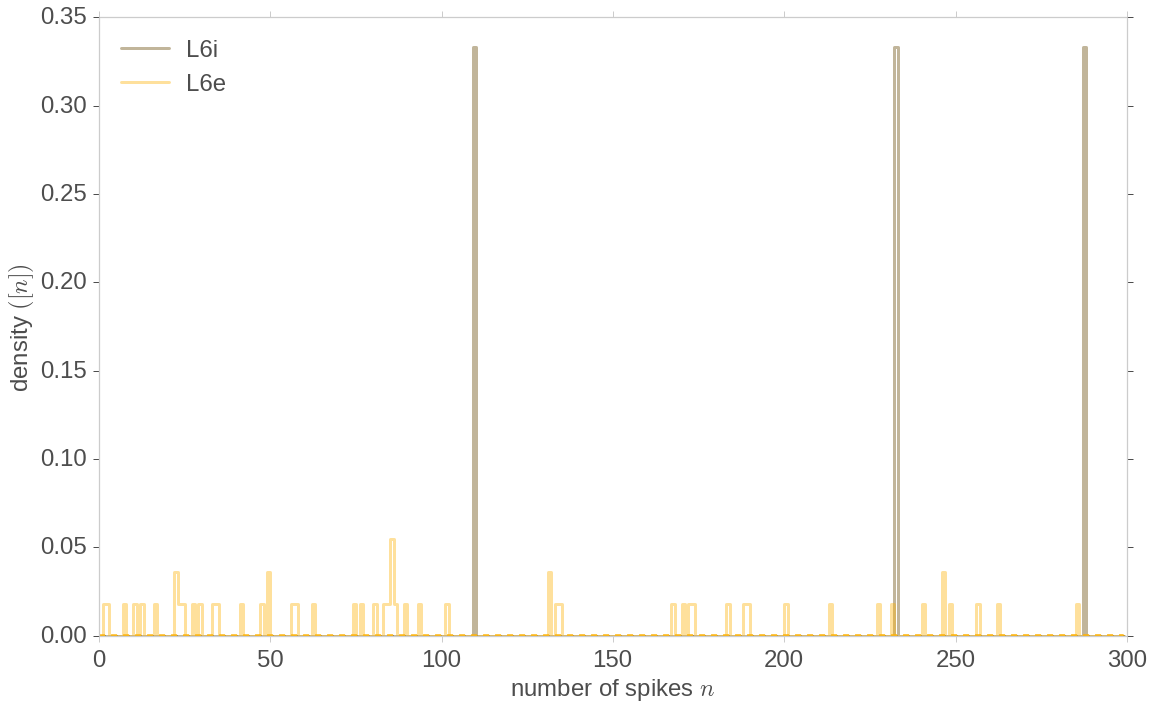

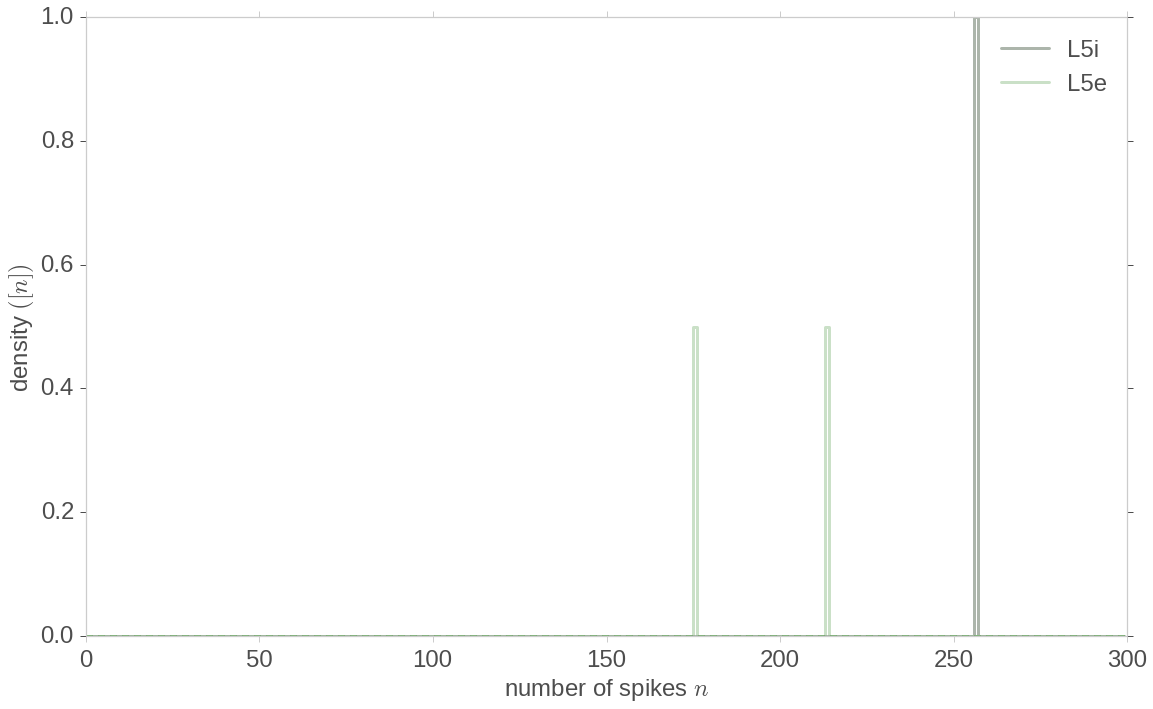

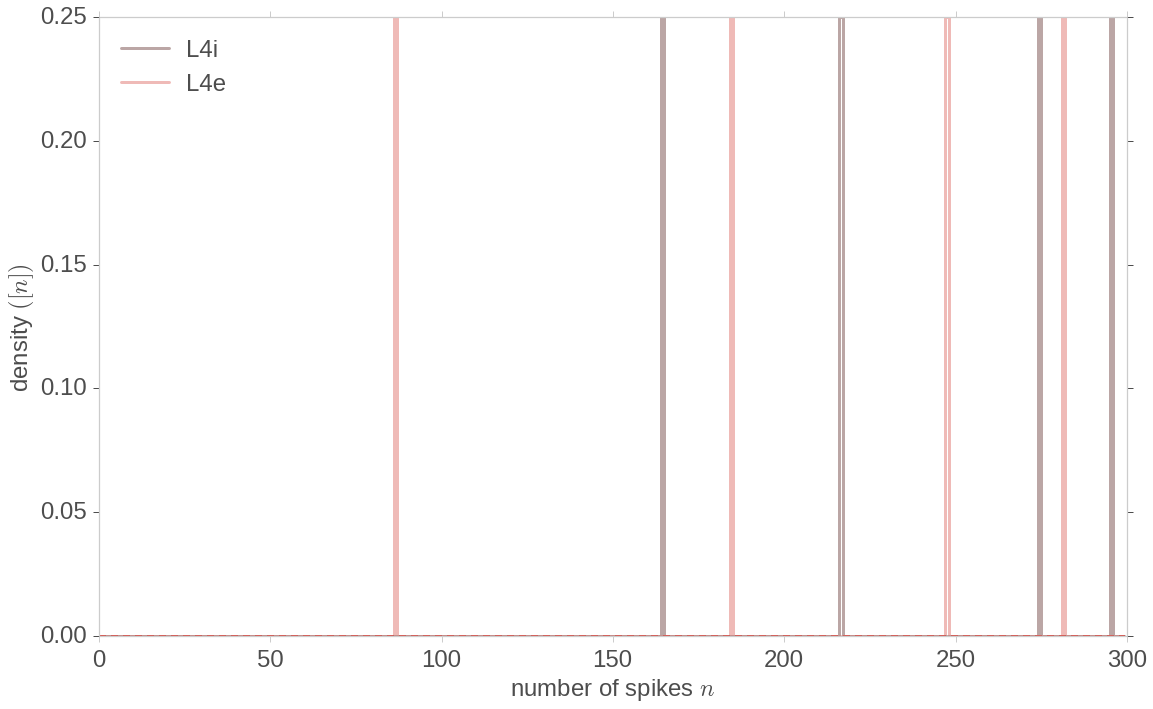

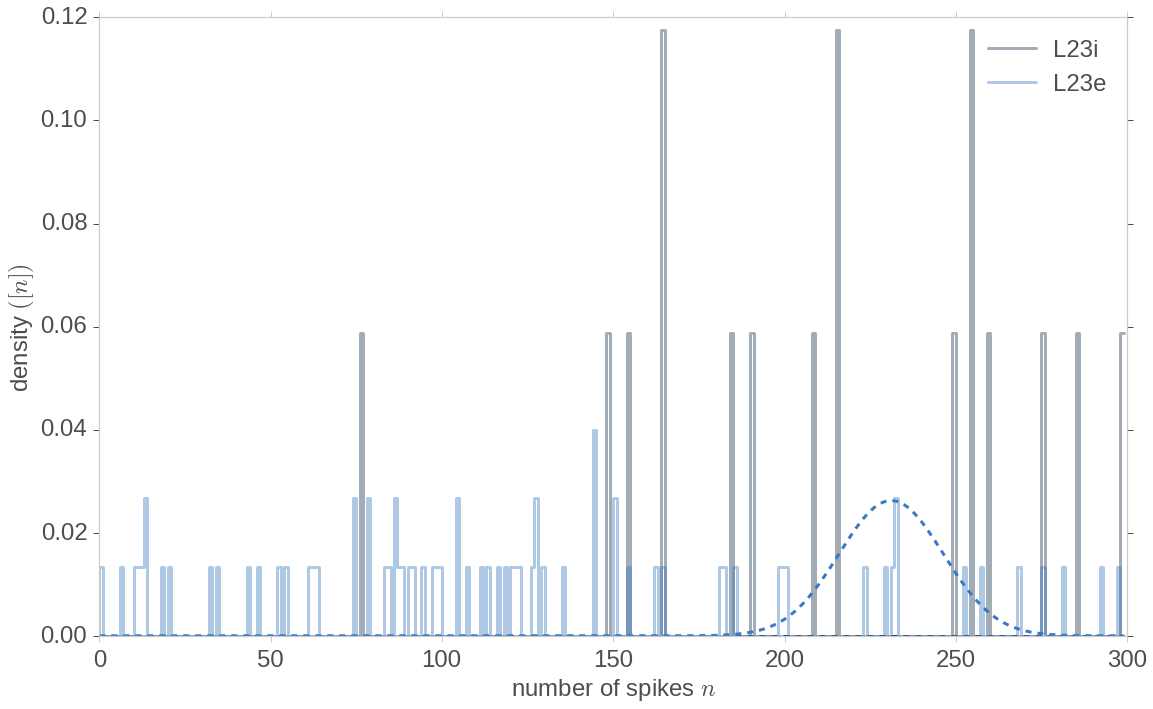

In [25]:
# Theory: P_T[n] = (r * T)**(n) / n! * exp(-r * T)
def P_n_spikes(n, rate, T=t_measure):
    from scipy.misc import factorial
    return (rate * T)**n / factorial(n) * np.exp(-rate * T)
def gauss(n, rate, T=t_measure):
    mu = rate * T
    sigma = np.sqrt(mu)
    return 1. / (np.sqrt(2 * np.pi) * sigma) * np.exp(- (n - mu)**2 / (2 * sigma**2))


print("<n>\tvar[n]\tfano")
for l, layer in enumerate(layers):
    fig = plt.figure()

    gridspec=plt.GridSpec(1, 1)
    subplotspec=gridspec.new_subplotspec((0, 0), rowspan=1, colspan=1)
    ax = fig.add_subplot(subplotspec)

    x_max = 0
    for i, population in enumerate(populations):
        if population.startswith(layer):
            rate = rates_mean[i]
            ax.plot(bins, hist_n_spikes[i] / np.sum(hist_n_spikes[i]), 
                     linewidth=3., color=colors[i], alpha=0.4, drawstyle="steps", label=population)
            ax.plot(bins, gauss(bins, rate), "--",
                     linewidth=3., color=colors[i], alpha=0.99)
            mean = rate * t_measure
            var = np.dot(hist_n_spikes[i], bins ** 2) / np.sum(hist_n_spikes[i]) - mean**2
            fano_factor = var / mean
            print("{0:6.2f}\t{1:6.2f}\t{2:6.2f}".format(rate * t_measure, var, fano_factor))
        
            # calc the upper xlim
            new_x_max = mean + 2 * np.sqrt(mean)
            if new_x_max > x_max:
                x_max = new_x_max
            
    #ax.set_xlim(0, x_max)
    ax.set_ylabel('density $([n])$')
    ax.set_xlabel('number of spikes $n$')
    ax.legend(loc="best")
    ax.grid(False)
    style.fixticks(ax)

    fig_name = "isi_histo_" + sim_spec

    fig_name += "_" + str(i)
    fig_name += picture_format

    if save_fig:
        print("save figure to " + fig_name)
        fig.savefig(os.path.join(figure_path,fig_name))
    else:
        suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
        suptitle += '\nfile: ' + sim_spec
        fig.suptitle(suptitle, y=0.98)

    if show_fig:
        fig.show()

# ISI statistics

## ISI distribution of single neuron

In [16]:
# neuron j of population i
i = 0 # population

bin_width = 0.01 # s
hist_max = 1. #s
n_bins_isi = int(hist_max / bin_width)
isi_bins = np.arange(0, hist_max, bin_width)


data_file = h5py.File(os.path.join(data_path, file_name), "r")
sim_spec2 = "0"
grp = data_file[sim_spec2 + "/spikes"]

population = populations[i]
subgrp = grp[str(population)]
raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
indices         = subgrp["rec_neuron_i"][:]

j_max = 1
hist_isi = np.zeros((j_max, n_bins_isi))
for j in range(j_max):
    times = raw_times_all[indices[j]:indices[j+1]]
    times = times[times > t_trans]

    # isi histogram
    n_spikes = len(times)
    if n_spikes > 1:
        isi = np.diff(times)
        hist_isi[j] = np.histogram(isi, bins=n_bins_isi, range=(0, hist_max), density=True)[0]
        mean_isi = np.mean(isi)
        var_isi  = np.var(isi)
        cv_isi   = var_isi / mean_isi**2

data_file.close()

### Plotting

save figure to isi_single_histo_a1.0_t300.2_totalN_00_L6i.pdf


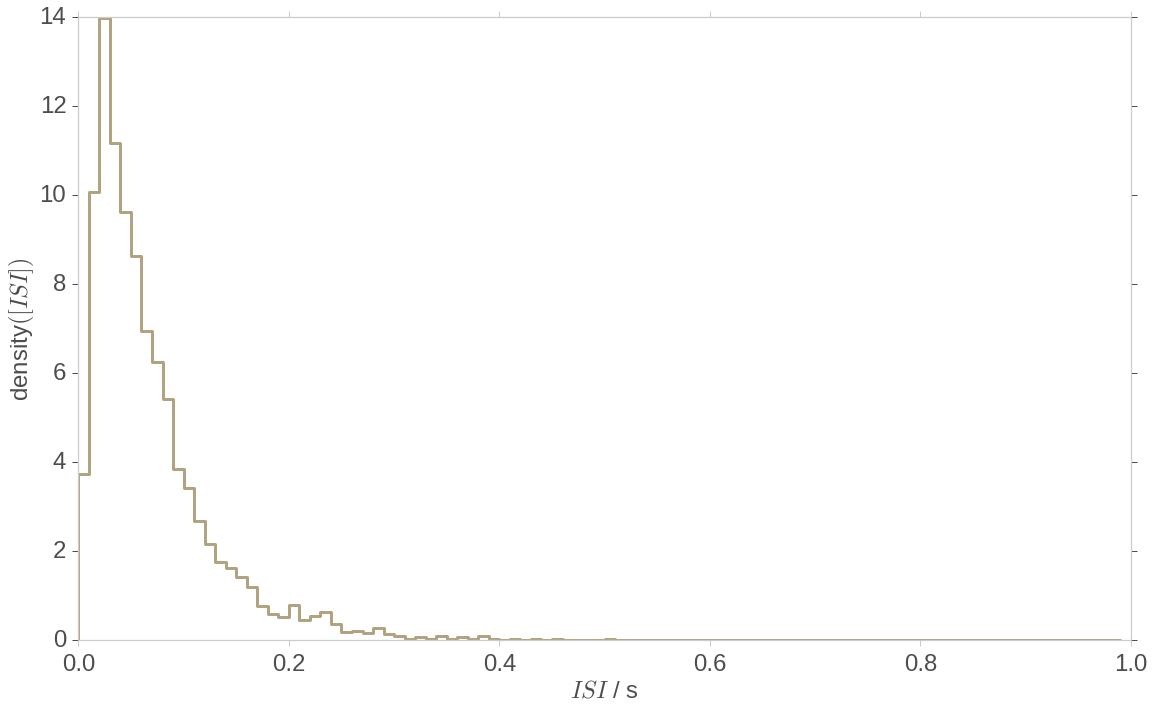

In [17]:
fig = plt.figure()
if not save_fig:
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec
    fig.suptitle(suptitle, y=0.98)

# Histogram of membrane pot
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

i = np.where(population==populations)[0][0]
# Histograms
for j in range(j_max):
    ax1.plot(isi_bins, hist_isi[j], 
         linewidth=3., color=colors[j], alpha=0.5, drawstyle="steps")


# Histogram
ax1.set_ylabel('density$([ISI])$')
ax1.set_xlabel('$ISI$ / s')
ax1.set_xlim(0, hist_max)
#ax1.set_ylim(0, 0.15)
ax1.grid(False)
ax1.legend(loc=0)
    
for ax in fig.axes:
    style.fixticks(ax)
fig_name = "isi_single_histo_" + sim_spec

fig_name += "_" + population
fig_name += picture_format

if save_fig:
    print("save figure to " + fig_name)
    fig.savefig(os.path.join(figure_path,fig_name))

if show_fig:
    fig.show()

## ISI distribution of populations

In [18]:
bin_width = 0.01 # s
hist_max = 6. #s
n_bins_isi = int(hist_max / bin_width)
isi_bins = np.arange(0, hist_max, bin_width)
density_isi = np.zeros((n_populations, n_bins_isi))

data_file = h5py.File(os.path.join(data_path, file_name), "r")
grp = data_file[sim_spec2 + "/spikes"]

for i, population in enumerate(populations):
    subgrp = grp[str(population)]
    raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
    indices         = subgrp["rec_neuron_i"][:]
        
    hist_isi_all = np.zeros(n_bins_isi)
    for j in range(len(indices) - 1):
        times = raw_times_all[indices[j]:indices[j+1]]
        times = times[times > t_trans]

        # isi histogram
        n_spikes = len(times)
        if n_spikes > 1:
            isi = np.diff(times)
            hist_isi_all += np.histogram(isi, bins=n_bins_isi, range=(0, hist_max), density=False)[0]
    
    density_isi[i] = hist_isi_all / (np.sum(hist_isi_all) * bin_width)
        
data_file.close()

save figure to isi_histo_a1.0_t300.2_totalN_00_0.pdf
save figure to isi_histo_a1.0_t300.2_totalN_00_1.pdf


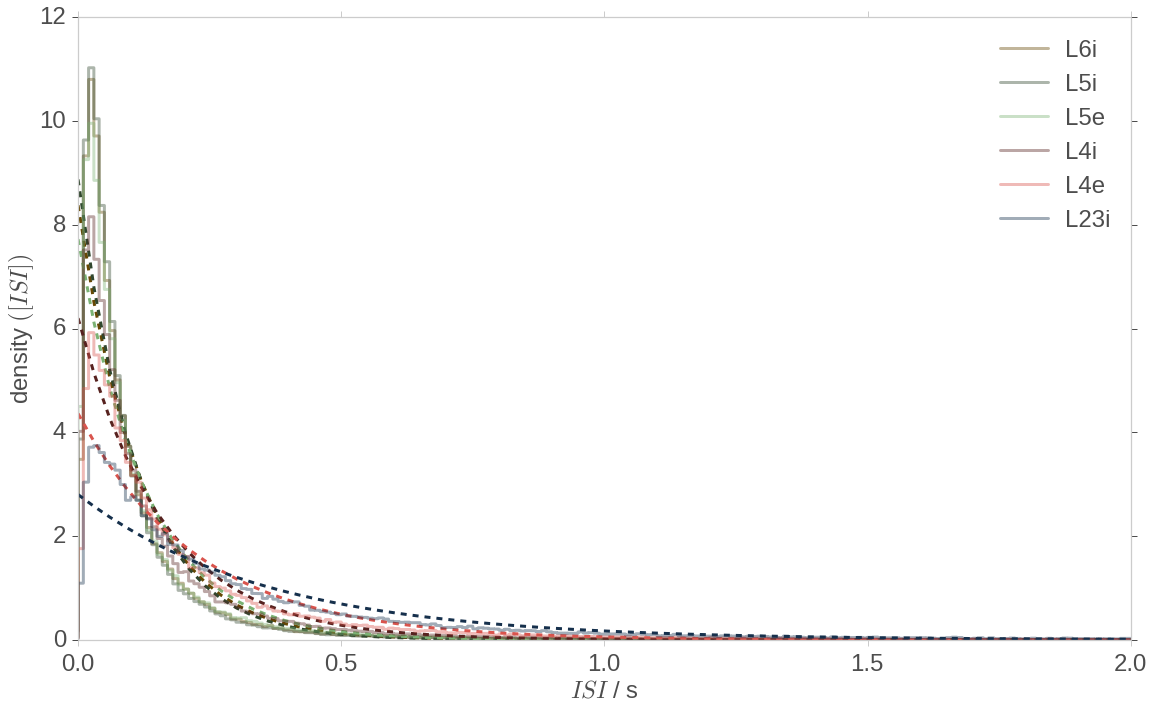

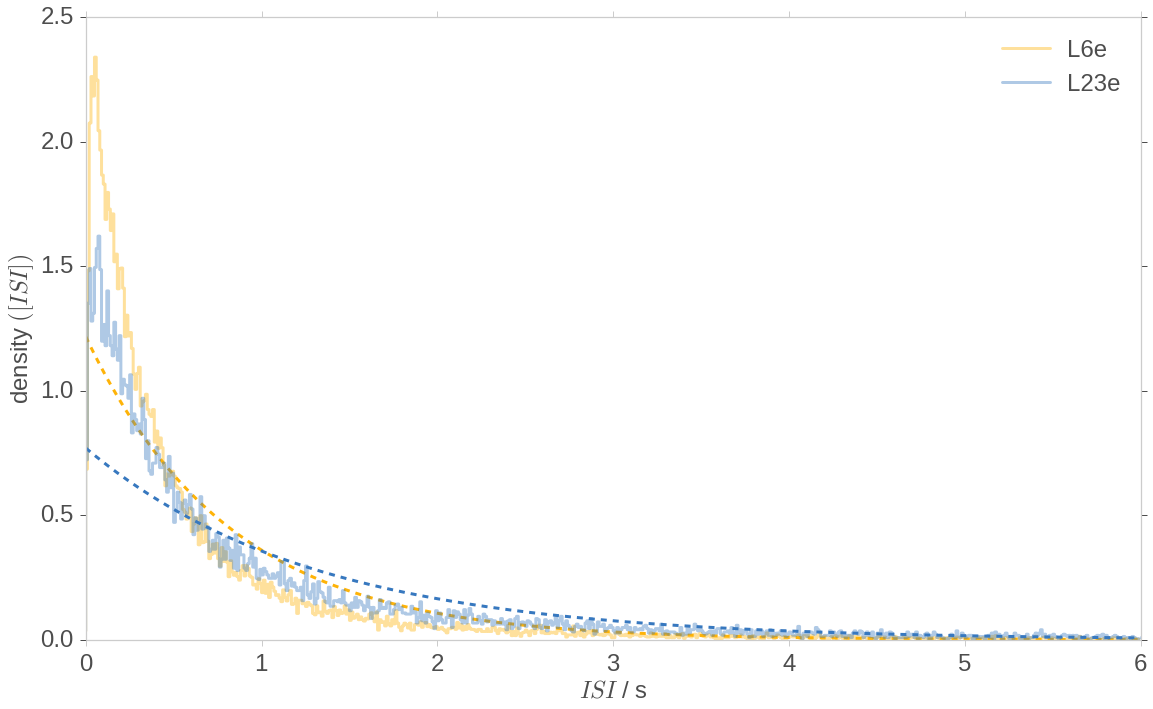

In [19]:
def density_theo(isi, rate):
    return(rate * np.exp(-rate * isi))
isi_cont = np.linspace(0, hist_max, 200)

fig0 = plt.figure()
fig1 = plt.figure()
all_figs = [fig0, fig1]
axs = []
gridspec=plt.GridSpec(1, 1)
subplotspec=gridspec.new_subplotspec((0, 0), rowspan=1, colspan=1)
for fig in all_figs:
    axs.append(fig.add_subplot(subplotspec))
ax0, ax1 = axs

for i, population in enumerate(populations):
    if (population != "L23e") and (population != "L6e"):
        ax0.plot(isi_bins, density_isi[i], 
                 linewidth=3., color=colors[i], alpha=0.4, drawstyle="steps", label=population)
        ax0.plot(isi_cont, density_theo(isi_cont, rates_mean[i]), "--", 
                 linewidth=3., color=colors[i])
    else:
        ax1.plot(isi_bins, density_isi[i], 
                 linewidth=3., color=colors[i], alpha=0.4, drawstyle="steps", label=population)
        ax1.plot(isi_cont, density_theo(isi_cont, rates_mean[i]), "--", 
                 linewidth=3., color=colors[i])

# Ranges
ax0.set_xlim(0, 2.)
ax1.set_xlim(0, 6.)

# Histograms
for ax in axs:
    ax.set_ylabel('density $([ISI])$')
    ax.set_xlabel('$ISI$ / s')
    ax.legend(loc="best")
    ax.grid(False)
    style.fixticks(ax)

for i, fig in enumerate(all_figs):
    fig_name = "isi_histo_" + sim_spec

    fig_name += "_" + str(i)
    fig_name += picture_format

    if save_fig:
        print("save figure to " + fig_name)
        fig.savefig(os.path.join(figure_path,fig_name))
    else:
        suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
        suptitle += '\nfile: ' + sim_spec
        fig.suptitle(suptitle, y=0.98)

    if show_fig:
        fig.show()

# Spike-train correlation 

In [20]:
# choose population(s)
i = 0 # population
population = populations[i]
# correlation between neuron j and k of population i
js = [0, 1]

# Data
with h5py.File(os.path.join(data_path, file_name), "r") as data_file:
    grp = data_file[sim_spec2 + "/spikes"]
    subgrp = grp[str(population)]
    raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
    indices         = subgrp["rec_neuron_i"][:]

# Histogram parameters
bin_width = 0.005 # s
n_bins = int(t_measure/ bin_width)

bins_ac = np.arange(bin_width, t_measure, bin_width)
acs = np.zeros((n_populations, n_bins-1))
bins_cc = np.arange(-t_measure, t_measure, bin_width)
ccs = np.zeros((n_populations, n_bins * 2 -1))

hist_times = np.zeros((2, n_bins))
for k, j in enumerate(js):
    times = raw_times_all[indices[j]:indices[j+1]]
    times = times[times > t_trans]
    
    hist_times[k] = (np.histogram(times, bins=n_bins, range=(0, t_measure), density=True)[0])
    
acs[i]     = np.correlate(hist_times[0], hist_times[0], mode="full")[n_bins:]
ccs[i]     = np.correlate(hist_times[0], hist_times[1], mode="full")

### Autocorrelation

save figure to autocorrelation_a1.0_t300.2_totalN_00_L6i_L6i.pdf


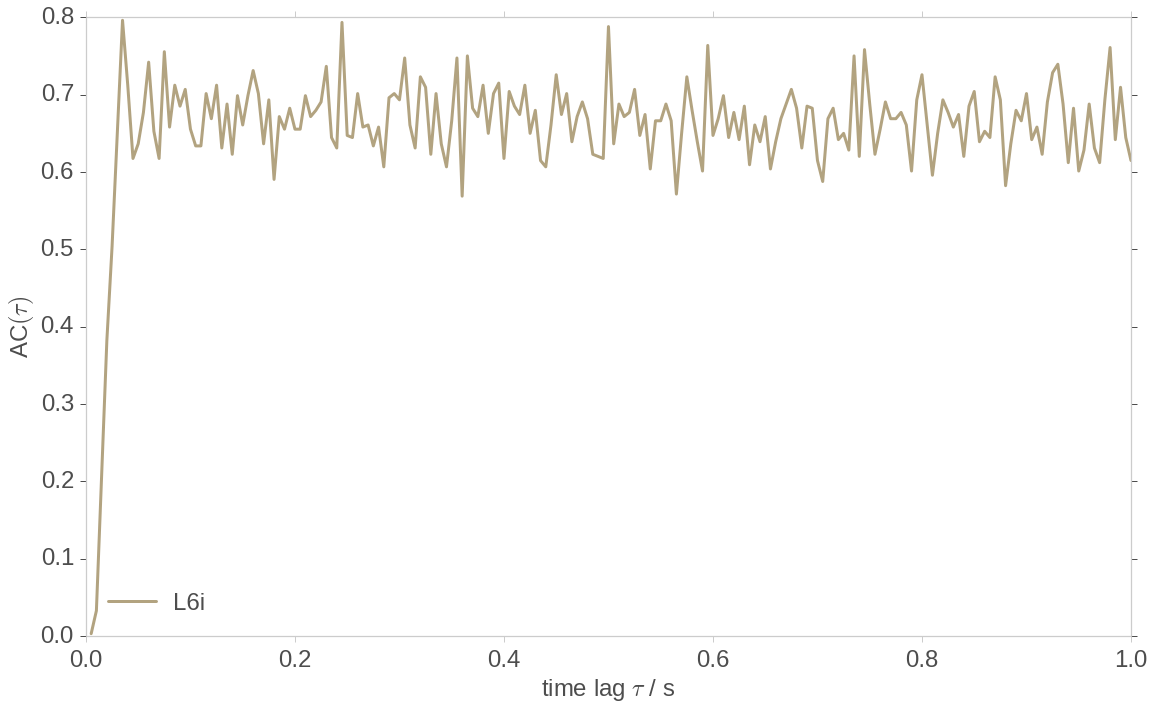

In [21]:
max_t = 1.0 # s
bins_red = bins_ac[bins_ac<= max_t]
ac_red  = acs[i][bins_ac<= max_t]

fig = plt.figure()
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

# Histograms
ax1.plot(bins_red, ac_red, "-",
     linewidth=3., color=colors[i], alpha=0.5, label=population)

# Histogram
ax1.set_ylabel('AC$(\\tau)$')
ax1.set_xlabel('time lag $\\tau$ / s')
ax1.set_xlim(0, max_t)
#ax1.set_ylim(0, 100)
ax1.grid(False)
ax1.legend(loc=0)
    
for ax in fig.axes:
    style.fixticks(ax)
fig_name = "autocorrelation_" + sim_spec + "_" + population

fig_name += "_" + population
fig_name += picture_format

if save_fig:
    print("save figure to " + fig_name)
    fig.savefig(os.path.join(figure_path,fig_name))
else:
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec
    fig.suptitle(suptitle, y=0.98)

if show_fig:
    fig.show()

### Spike train cross correlations

save figure to correlation_a1.0_t300.2_totalN_00_L6i_L6i.pdf


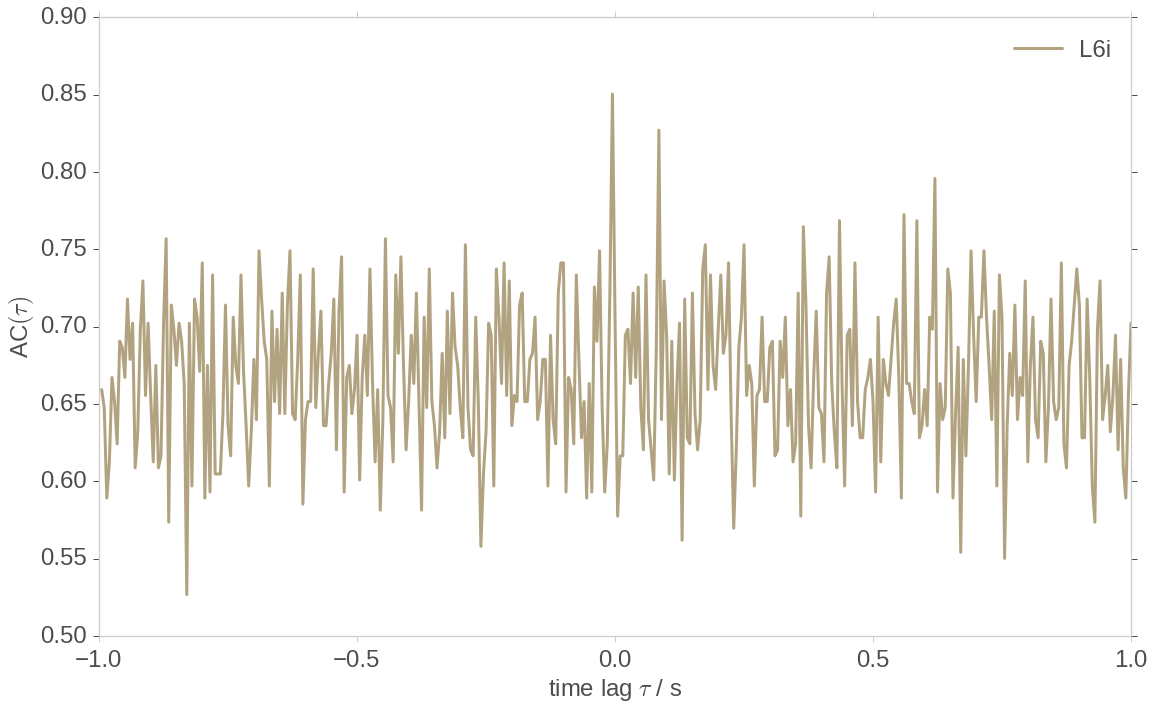

In [22]:
max_t = 1. # s
bins_red = bins_cc[abs(bins_cc)<= max_t]
cc_red  = ccs[i][abs(bins_cc)<= max_t]

fig = plt.figure()
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

# Histograms
ax1.plot(bins_red, cc_red, "-",
     linewidth=3., color=colors[i], alpha=0.5, label=population)

# Histogram
ax1.set_ylabel('AC$(\\tau)$')
ax1.set_xlabel('time lag $\\tau$ / s')
ax1.set_xlim(-max_t, max_t)
#ax1.set_ylim(0, 100)
ax1.grid(False)
ax1.legend(loc=0)
    
for ax in fig.axes:
    style.fixticks(ax)
fig_name = "correlation_" + sim_spec + "_" + population

fig_name += "_" + population
fig_name += picture_format

if save_fig:
    print("save figure to " + fig_name)
    fig.savefig(os.path.join(figure_path,fig_name))
else:
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec
    fig.suptitle(suptitle, y=0.98)

if show_fig:
    fig.show()